# Coronavirus testing locations

### Load python tools

In [1]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()
from selenium import webdriver
driver = webdriver.Chrome(executable_path='/Users/mhustiles/Desktop/chromedriver')

### CDC testing capacity

In [25]:
testing = pd.read_csv('input/testing_locations_20200430.csv')

In [26]:
testing = testing.drop({'Unnamed: 4', 'Unnamed: 5'}, axis=1)

In [ ]:
testing.columns = testing.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [115]:
testing.head()

,county,site_name,phone,address
0,Alameda,"Alta Bates Summit Medical Center, Alta Bates C...",510-204-4444,"2450 Ashby Avenue, Berkeley, CA 94705"
1,Alameda,"Alta Bates Summit Medical Center, Herrick Campus",510-204-4444,"2001 Dwight Way, Berkeley, CA 94704"
2,Alameda,Carbon Health - Berkeley,510-686-3621,"2920 Telegraph Ave, Berkeley CA 94705"
3,Alameda,Carbon Health - Oakland,510-844-4097,"411 Grand Ave, Oakland, CA 94610"
4,Alameda,Dublin Walk-In Care,800-972-5547,"3918 Fallon Road, Dublin, CA 94568"


In [116]:
testing.to_csv('output/addresses.csv', index=None)

### Read Geocoded addresses

In [117]:
locations = pd.read_csv('output/output.csv')

In [118]:
locations.accuracy.value_counts()

ROOFTOP               242
RANGE_INTERPOLATED      5
GEOMETRIC_CENTER        2
Name: accuracy, dtype: int64

### Drop 7 sites without a good location

In [119]:
locations = locations[(locations['accuracy'] == 'ROOFTOP') \
                      & (locations['formatted_address'].str.contains(', CA '))]

In [120]:
testing_locations_geo = gpd.GeoDataFrame(
    locations, geometry=gpd.points_from_xy(locations.longitude, locations.latitude))

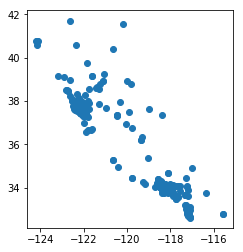

In [121]:
testing_locations_geo.plot()

In [122]:
testing_locations_geo.crs = {'init': "epsg:4326"}

In [123]:
testing_locations_geo.to_file('output/testing_locations_geo.geojson', driver='GeoJSON')

In [124]:
!tippecanoe --generate-ids --force -r1 -pk -pf -o \
output/testing_locations_geo.mbtiles \
output/testing_locations_geo.geojson

For layer 0, using name "testing_locations_geo"
241 features, 16741 bytes of geometry, 16 bytes of separate metadata, 334930 bytes of string pool
  99.9%  14/2838/6539  


---

### CA county geography

In [125]:
county_geo = gpd.read_file('/Users/mhustiles/data/data/gis/ca-counties.geojson')

In [126]:
la_county_geo = gpd.read_file('/Users/mhustiles/data/data/gis/LA/lacountyboundary.geojson')

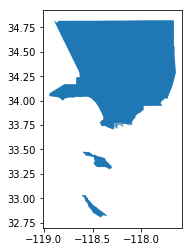

In [127]:
la_county_geo.plot()

In [128]:
county_geo.crs = {'init': "epsg:4326"}

In [129]:
county_geo.columns = county_geo.columns.str.lower()

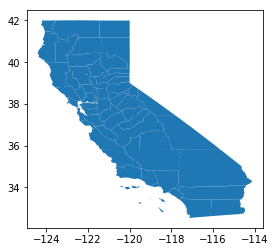

In [130]:
county_geo.plot()

---

### Merge with other dataframes

In [131]:
counties_testing = gpd.sjoin(testing_locations_geo, county_geo, how="inner", op='intersects')

In [132]:
counties_la_testing = gpd.sjoin(testing_locations_geo, la_county_geo, how="inner", op='intersects')

In [133]:
counties_testing_counts = counties_testing.groupby(['name']).agg('size').reset_index(name='sites')

In [134]:
counties_testing_counts.sort_values(by='sites', ascending=False)

,name,sites
12,Los Angeles,69
28,San Diego,20
29,San Francisco,18
0,Alameda,16
34,Santa Clara,13
23,Orange,13
3,Contra Costa,8
32,San Mateo,7
27,San Bernardino,6
25,Riverside,6


In [135]:
counties_testing_counts.to_csv('output/counties_testing_counts.csv')

### Merge testing counts to county polygons

In [136]:
county_geo_testing = county_geo.merge(counties_testing_counts, on='name', how='left')

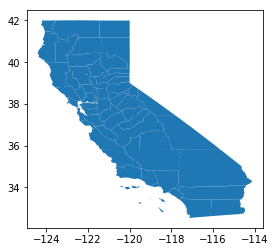

In [137]:
county_geo_testing.plot()

In [138]:
county_geo_testing.to_file('output/county_geo_testing.geojson', driver='GeoJSON')

In [139]:
counties_la_testing.to_file('output/county_la_testing.geojson', driver='GeoJSON')